# IRF handling and data reduction in Gammapy


## Tutorial overview

This notebook shows how to

- visualising observations
- loading and visualising instrument response functions (IRFs) using Gammapy
- how to perform data reduction of IACT data
    - for a FoV background method (best for maps)

## Setup


You should already have gammapy v1.2 installed on your machine, as per the instructions on the main GitHub page or via https://docs.gammapy.org/1.2/getting-started/index.html


## Jupyter tips:
If you are interested in knowing how to use a function you can use the `?`:

`MapDataset?`


To know what functions you have access to for a definition, you can use 'tab completion':

`data_store.` Then hit tab



## Import all the necessary libraries for the tutorial

In [1]:
from astropy.coordinates import SkyCoord
import astropy.units as u
from regions import CircleSkyRegion
import matplotlib.pyplot as plt
import numpy as np

from gammapy.data import DataStore
from gammapy.datasets import MapDataset, Datasets
from gammapy.estimators import ExcessMapEstimator
from gammapy.maps import MapAxis, WcsGeom, RegionGeom
from gammapy.makers import (
    MapDatasetMaker,
    SafeMaskMaker,
    FoVBackgroundMaker,
)

In [2]:
data_store = DataStore.from_dir(f"$GAMMAPY_DATA/hess-dl3-dr1")

**Lets look at the information for that datastore.**

In [3]:
data_store.info()

Data store:
HDU index table:
BASE_DIR: /home/feijen/gammapy-datasets/1.2/hess-dl3-dr1
Rows: 630
OBS_ID: 20136 -- 47829
HDU_TYPE: ['aeff', 'bkg', 'edisp', 'events', 'gti', 'psf']
HDU_CLASS: ['aeff_2d', 'bkg_3d', 'edisp_2d', 'events', 'gti', 'psf_table']


Observation table:
Observatory name: 'N/A'
Number of observations: 105



In [4]:
target_position = SkyCoord.from_name('RX J1713.7-3946').galactic

**What are the galactic coordinates of this source?**

In [5]:
print(target_position)

<SkyCoord (Galactic): (l, b) in deg
    (347.26945653, -0.25689328)>


We can now define an observation filter to select only the relevant observations. Here we use a cone search which we define with a python dict.

We then filter the ObservationTable with `~gammapy.data.ObservationTable.select_observations()`.


In [6]:
selection = dict(
    type="sky_circle",
    frame="galactic",
    lon=target_position.l,
    lat=target_position.b,
    radius="5 deg",
)
selected_obs_table = data_store.obs_table.select_observations(selection)

**Look at what is in that selected table**

In [7]:
selected_obs_table

OBS_ID,RA_PNT,DEC_PNT,GLON_PNT,GLAT_PNT,ZEN_PNT,ALT_PNT,AZ_PNT,OBJECT,RA_OBJ,DEC_OBJ,OFFSET_OBJ,ONTIME,LIVETIME,DEADC,TSTART,TSTOP,DATE-OBS,TIME-OBS,DATE-END,TIME-END,N_TELS,TELLIST,QUALITY,MUONEFF,EVENT_COUNT,TARGET_NAME,TARGET_TAG,TARGET_OFFSET,SAFE_ENERGY_LO,SAFE_ENERGY_HI
,deg,deg,deg,deg,deg,deg,deg,,deg,deg,deg,s,s,,s,s,,,,,,,,,,,,deg,TeV,TeV
int64,float32,float32,float32,float32,float32,float32,float32,bytes18,float32,float32,float32,float32,float32,float32,float64,float64,bytes10,bytes12,bytes10,bytes12,int64,bytes7,int64,float32,int64,bytes21,bytes14,float32,float32,float32
20326,259.29852,-39.762222,347.74036,-1.0417831,18.712194,71.2878,154.81943,RXJ 1713.7-3946,258.3879,-39.762222,0.6999909,1683.0,1500.009,0.891271,103858277.0,103859960.0,2004-04-17,01:32:21.184,2004-04-17,02:00:24.184,4,"1,2,3,4",0,1.1412385,16880,RX J1713.7-3946,rxj1713,0.7252947,0.23442288,100.0
20327,257.47733,-39.762222,346.91946,0.092252225,16.734882,73.265114,173.0282,RXJ 1713.7-3946,258.3879,-39.762222,0.69996744,1683.0,1497.074,0.889527,103860109.0,103861792.0,2004-04-17,02:02:53.184,2004-04-17,02:30:56.184,4,"1,2,3,4",0,1.1392112,16995,RX J1713.7-3946,rxj1713,0.6746846,0.20417379,100.0
20349,259.29852,-39.762222,347.74036,-1.0417831,16.722466,73.277534,186.67764,RXJ 1713.7-3946,258.3879,-39.762222,0.6999909,1682.0,1494.5023,0.888527,103947504.0,103949186.0,2004-04-18,02:19:28.184,2004-04-18,02:47:30.184,4,"1,2,3,4",0,1.1592567,16141,RX J1713.7-3946,rxj1713,0.7252947,0.20417379,100.0
20350,257.47733,-39.762222,346.91946,0.092252225,18.658506,71.34149,204.89865,RXJ 1713.7-3946,258.3879,-39.762222,0.69996744,1682.0,1497.6545,0.890401,103949330.0,103951012.0,2004-04-18,02:49:54.184,2004-04-18,03:17:56.184,4,"1,2,3,4",0,1.1565586,16081,RX J1713.7-3946,rxj1713,0.6746846,0.23442288,100.0
20396,258.3879,-39.06222,347.8998,-0.062237248,16.931627,73.068375,190.61954,RXJ 1713.7-3946,258.3879,-39.762222,0.70000076,1683.0,1499.001,0.89067197,104120195.0,104121878.0,2004-04-20,02:17:39.184,2004-04-20,02:45:42.184,4,"1,2,3,4",0,1.1642822,16418,RX J1713.7-3946,rxj1713,0.7092343,0.20417379,100.0
20397,258.3879,-40.462223,346.76566,-0.8830993,19.253716,70.746284,207.88188,RXJ 1713.7-3946,258.3879,-39.762222,0.70000076,1682.0,1505.1713,0.89487,104122008.0,104123690.0,2004-04-20,02:47:52.184,2004-04-20,03:15:54.184,4,"1,2,3,4",0,1.1711123,15798,RX J1713.7-3946,rxj1713,0.691681,0.23442288,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20518,258.3879,-39.06222,347.8998,-0.062237248,16.80531,73.194695,171.5077,RXJ 1713.7-3946,258.3879,-39.762222,0.70000076,1682.0,1506.199,0.895481,104463121.0,104464803.0,2004-04-24,01:33:05.184,2004-04-24,02:01:07.184,4,"1,2,3,4",0,1.1684012,14636,RX J1713.7-3946,rxj1713,0.7092343,0.20417379,100.0



We can now retrieve the relevant observations by passing their obs_id to the `~gammapy.data.DataStore.get_observations()` method.


In [8]:
observations = data_store.get_observations(selected_obs_table["OBS_ID"])

**View those observations**

In [9]:
print(observations)

Observations
Number of observations: 15
Observation

	obs id            : 20326 
 	tstart            : 53112.06
	tstop             : 53112.08
	duration          : 1683.00 s
	pointing (icrs)   : 259.3 deg, -39.8 deg

	deadtime fraction : 10.9%
Observation

	obs id            : 20327 
 	tstart            : 53112.09
	tstop             : 53112.10
	duration          : 1683.00 s
	pointing (icrs)   : 257.5 deg, -39.8 deg

	deadtime fraction : 11.0%
Observation

	obs id            : 20349 
 	tstart            : 53113.10
	tstop             : 53113.12
	duration          : 1682.00 s
	pointing (icrs)   : 259.3 deg, -39.8 deg

	deadtime fraction : 11.1%
Observation

	obs id            : 20350 
 	tstart            : 53113.12
	tstop             : 53113.14
	duration          : 1682.00 s
	pointing (icrs)   : 257.5 deg, -39.8 deg

	deadtime fraction : 11.0%
Observation

	obs id            : 20396 
 	tstart            : 53115.10
	tstop             : 53115.12
	duration          : 1683.00 s
	pointing (icrs


# Exploring the data contained in a single observation

In gammapy, you can have a view of the content of an object with the `peek()` method. You can use it on a `Observation`. It will show synthetic views of the IRFs.

Note: above we defined `Observations`, so we wish to select just one of those.

In [10]:
obs = observations[0]

## Events

In [11]:
events = obs.events
print(events)

EventList
---------

  Instrument       : H.E.S.S. Phase I
  Telescope        : HESS
  Obs. ID          : 20326

  Number of events : 16880
  Event rate       : 10.030 1 / s

  Time start       : 53112.06413407407
  Time stop        : 53112.08361324074

  Min. energy      : 1.65e-01 TeV
  Max. energy      : 8.84e+01 TeV
  Median energy    : 2.78e-01 TeV

  Max. offset      : 58.5 deg



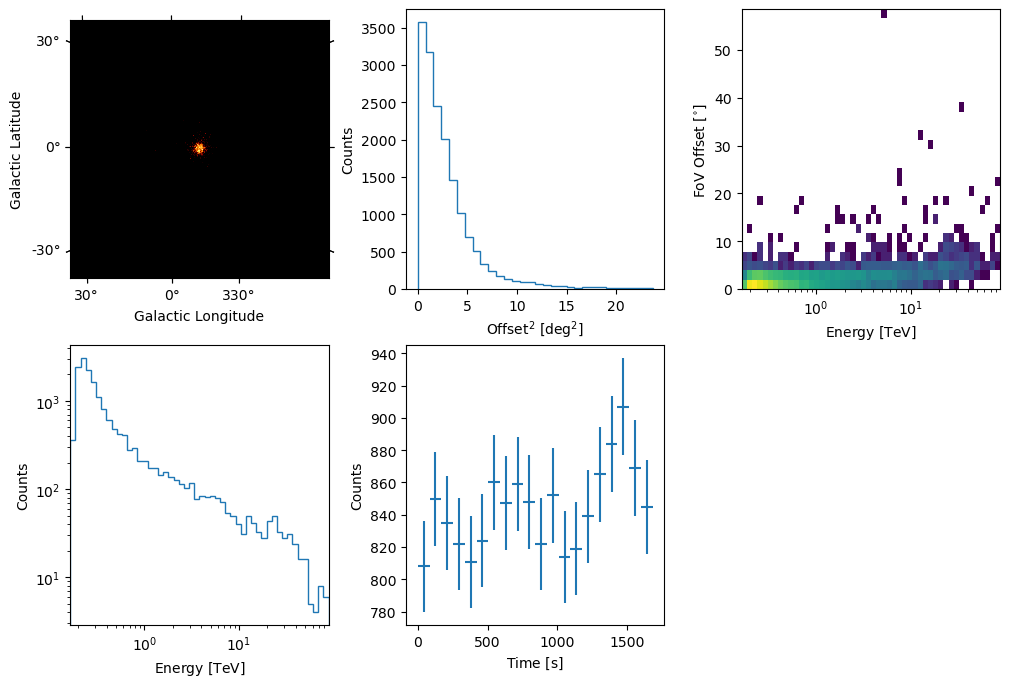

In [12]:
events.peek()

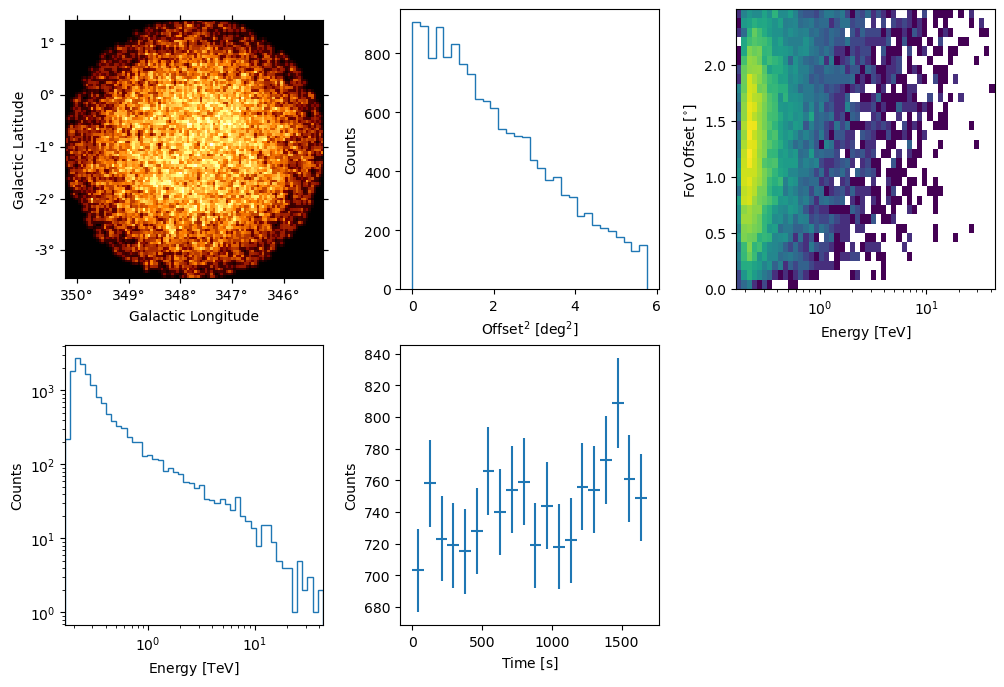

In [13]:
obs.events.select_offset([0, 2.5] * u.deg).peek()

## Viewing the various IRFs for the observation

### Effective area
- stored as a function of energy an offset

/home/feijen/anaconda3/envs/gammapy-1.2-withray/lib/python3.10/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


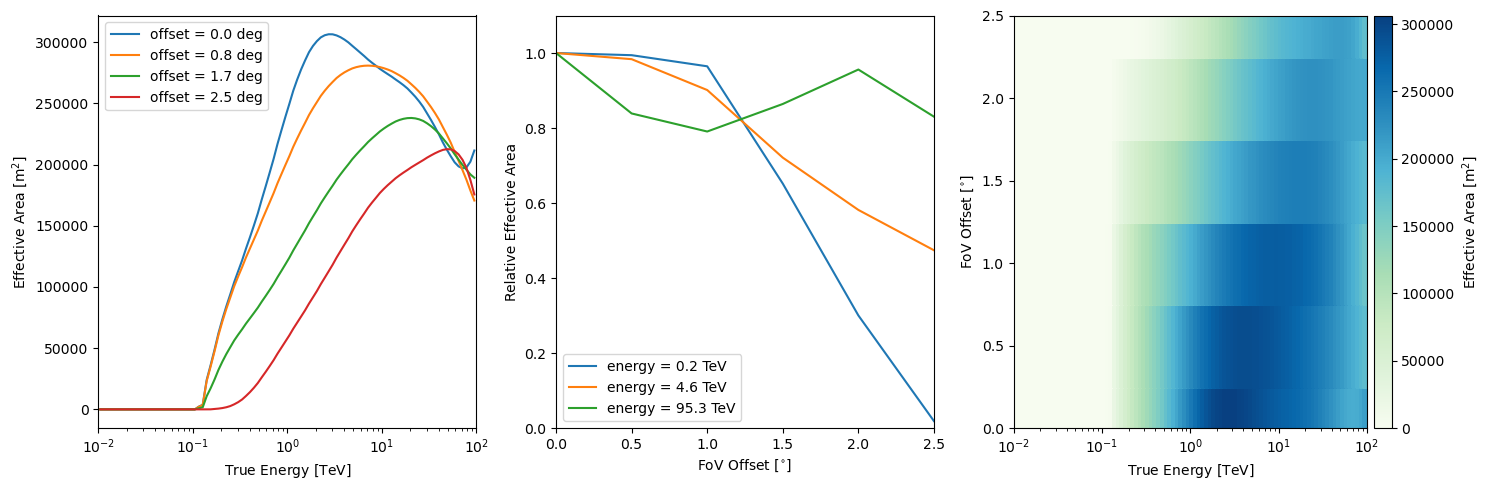

In [14]:
obs.aeff.peek()

# Exercise:
- Peek into each of the other irfs for a quick look

### Point Spread Function (PSF)

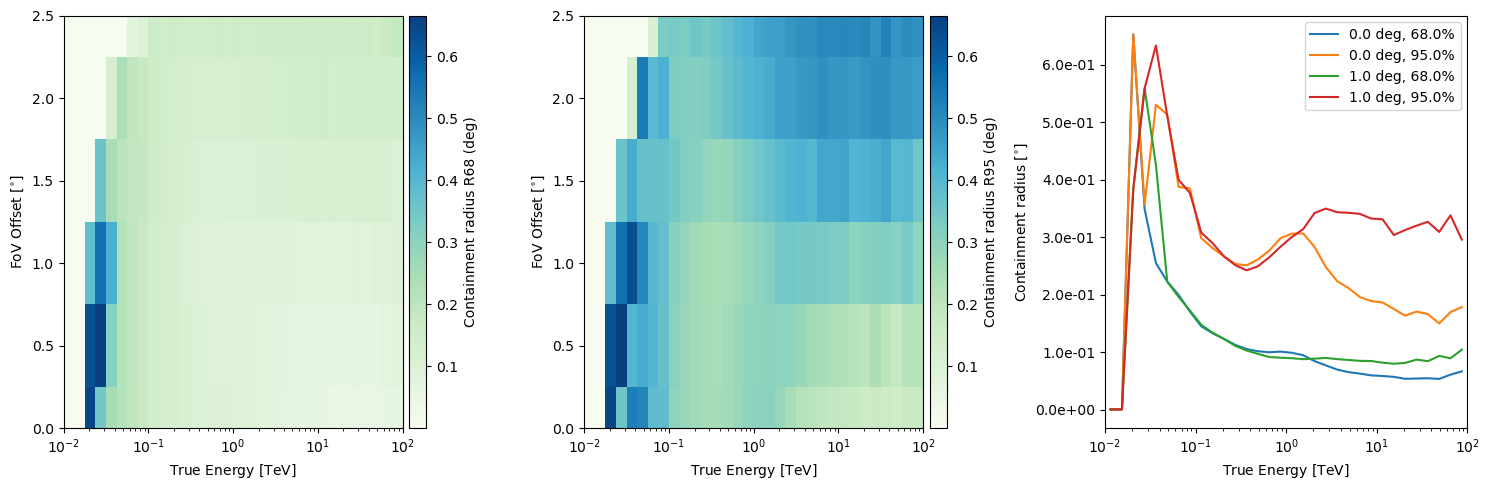

In [15]:
obs.psf.peek()

## Energy dispersion

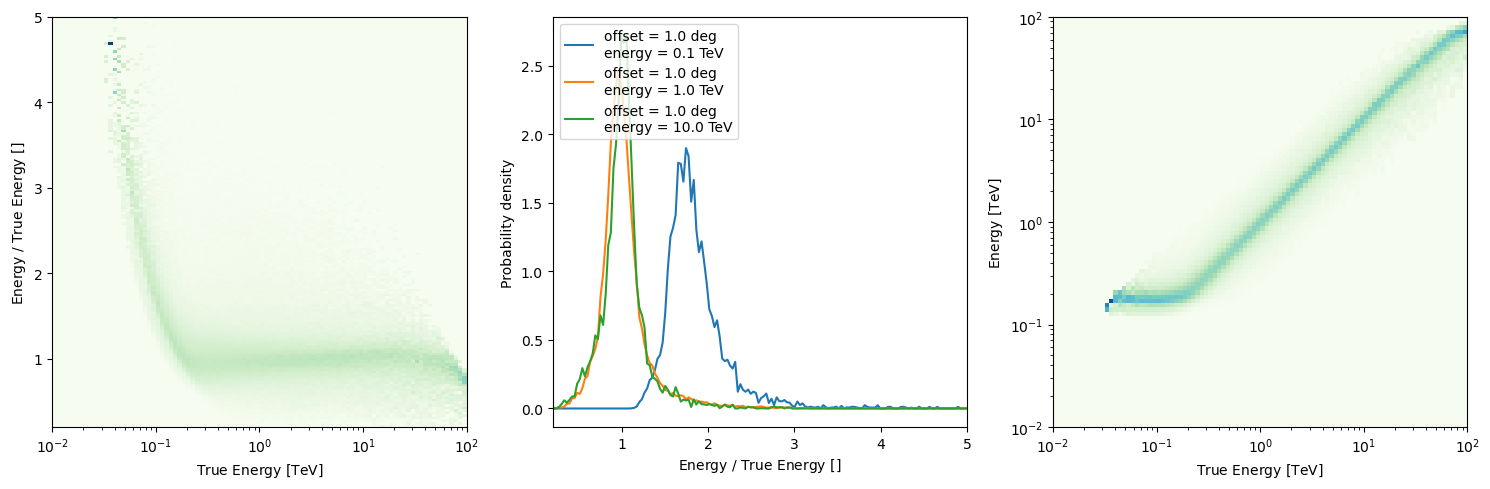

In [16]:
obs.edisp.peek()

## Background
- hardonic background reconstructed as gamma-like

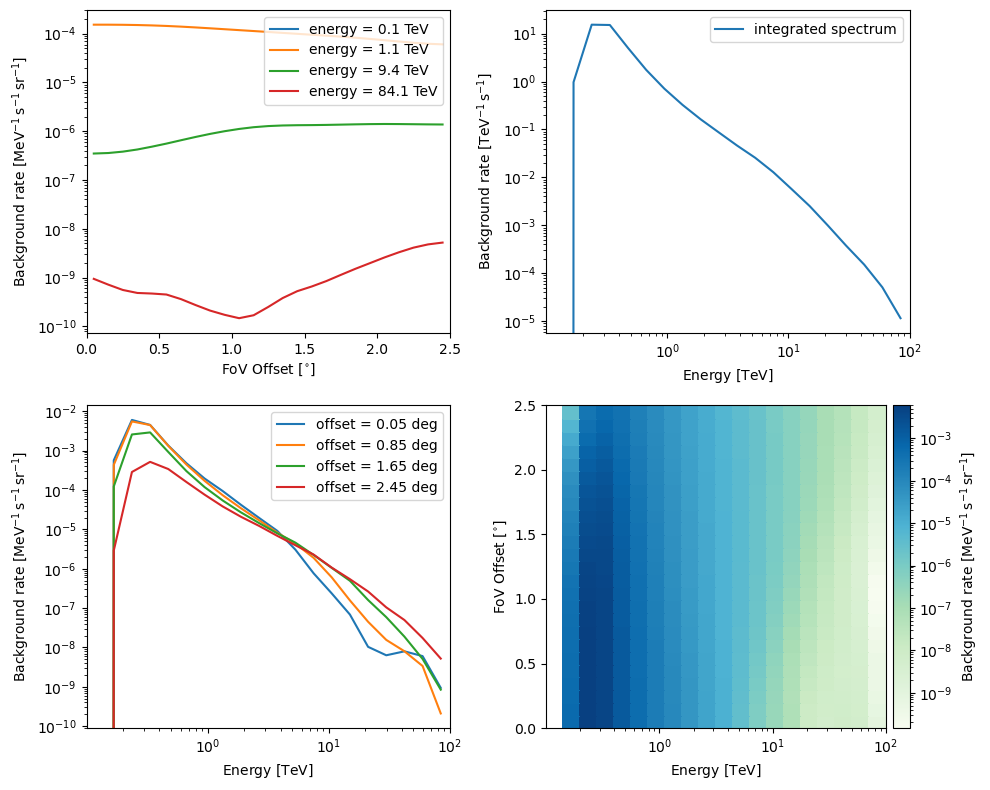

In [17]:
obs.bkg.peek()

# Preparing reduced datasets geometry

We define a reference geometry for our analysis.

We choose a WCS based geometry. We define the center of the geometry by our target source, assign a binsize of 0.02 deg, the width of the geometry, and also define an energy axis.

This geometry will be what our final dataset will look like.

In [18]:
energy_axis = MapAxis.from_energy_bounds(0.3, 10.0, 15, unit="TeV")

geom = WcsGeom.create(
    skydir=target_position,
    binsz=0.02,
    width=(6, 6),
    frame="galactic",
    axes=[energy_axis],
)

# Reduced IRFs are defined in true energy (i.e. not measured energy).
energy_axis_true = MapAxis.from_energy_bounds(
    0.1, 20, 20, unit="TeV", name="energy_true"
)

Important: we have both a 'true' energy axis and 'reconstructed' energy axis. We must ensure that the true axis is both wider in energy and contains more bins than the 'reco'.

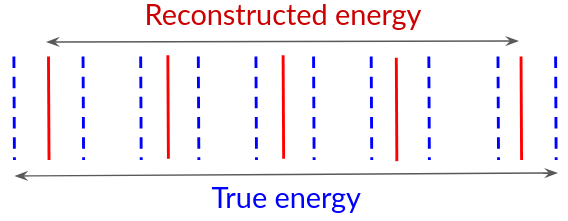

In [19]:
print(geom)

WcsGeom

	axes       : ['lon', 'lat', 'energy']
	shape      : (300, 300, 15)
	ndim       : 3
	frame      : galactic
	projection : CAR
	center     : 347.3 deg, -0.3 deg
	width      : 6.0 deg x 6.0 deg
	wcs ref    : 347.3 deg, -0.3 deg




# Data reduction - FoV background method!

Create the maker classes to be used

The `~gammapy.datasets.MapDatasetMaker` object is initialized as well as the `~gammapy.makers.SafeMaskMaker` that carries here a maximum offset selection.


In [20]:
stacked = MapDataset.create(
    geom=geom, energy_axis_true=energy_axis_true, name="rxj-stacked"
)

We need to mask out any sources with significant emission.

You can check the http://gamma-sky.net to see if there are sources in the FoV. We see that the target source is the only one. So we need to create an exclusion region based on that source.

In [21]:
circle = CircleSkyRegion(
    center=target_position, radius=0.8 * u.deg
)
exclusion_mask = ~geom.region_mask(regions=[circle])

**Try to plot that exclusion mask**

In [22]:
exclusion_mask.plot_interactive()
plt.show()

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

Create the `makers`.

In [23]:
maker = MapDatasetMaker(selection=['counts','background', 'psf', 'edisp', 'exposure'])
safe_mask_maker = SafeMaskMaker(
    methods=["offset-max", "aeff-max", "bkg-peak"], offset_max="2.3 deg"
)
fov_bkg_maker = FoVBackgroundMaker(method="fit", exclusion_mask=exclusion_mask)

In [24]:
for obs in observations:
    dataset = maker.run(stacked, obs)
    dataset = safe_mask_maker.run(dataset, obs)
    dataset = fov_bkg_maker.run(dataset)
    print(
        f"Background norm obs {obs.obs_id}: {dataset.background_model.spectral_model.norm.value:.2f}"
    )
    stacked.stack(dataset)

Background norm obs 20326: 1.05
Background norm obs 20327: 1.06
Background norm obs 20349: 1.00
Background norm obs 20350: 1.06
Background norm obs 20396: 1.00
Background norm obs 20397: 1.07
Background norm obs 20421: 1.07
Background norm obs 20422: 1.01
Background norm obs 20517: 1.01
Background norm obs 20518: 0.97
Background norm obs 20519: 1.00
Background norm obs 20521: 1.03
Background norm obs 20898: 1.14
Background norm obs 20899: 1.05
Background norm obs 20900: 0.99


We also have the ability to perform this loop through the `DatasetsMaker` although we cannot currently save or print any of the information in the loop.

```python
global_dataset = MapDataset.create(
    geom=geom, energy_axis_true=energy_axis_true, name="rxj-stacked"
)
makers = [dataset_maker, safe_mask_maker, fov_bkg_maker]
datasets_maker = DatasetsMaker(makers, stack_datasets=True, n_jobs=1, cutout_mode='partial')
datasets = datasets_maker.run(global_dataset, observations)
```

In [25]:
print(stacked)

MapDataset
----------

  Name                            : rxj-stacked 

  Total counts                    : 74124 
  Total background counts         : 71944.71
  Total excess counts             : 2179.29

  Predicted counts                : 71944.71
  Predicted background counts     : 71944.71
  Predicted excess counts         : nan

  Exposure min                    : 3.54e+05 m2 s
  Exposure max                    : 6.48e+09 m2 s

  Number of total bins            : 1350000 
  Number of fit bins              : 1058640 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : nan

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




We can save this file so that later you can manipulate it!

In [26]:
stacked.write('stacked_MapDataset.fits')

We can also `peek` this, just like we did with the observations.

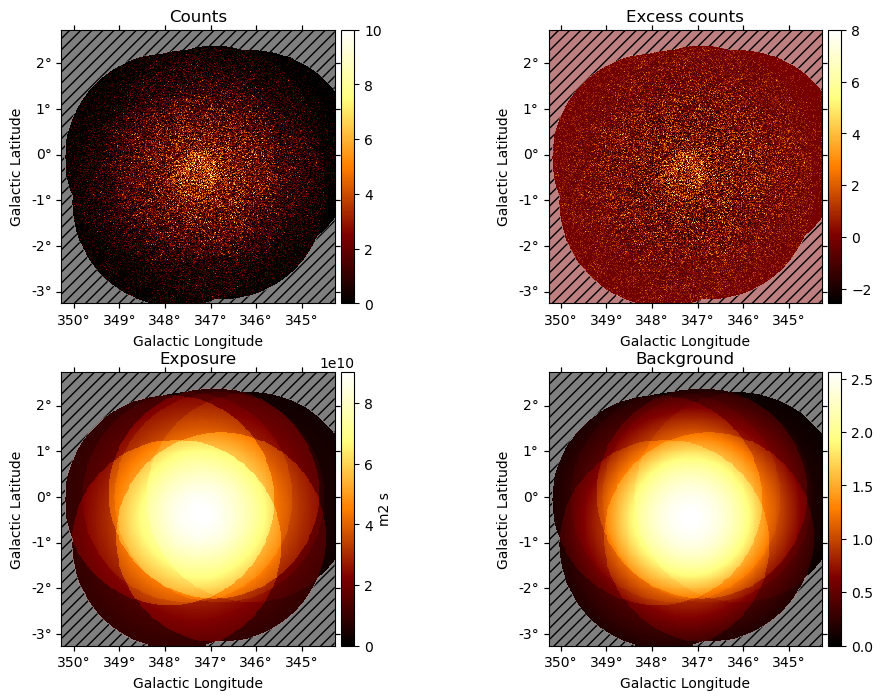

In [27]:
stacked.peek()

It looks like we have some source based on the counts image but it is hard to discern. This is because we have a map with very fine binning, so to view this better we can plot (for example) a counts map which has been smoothed.

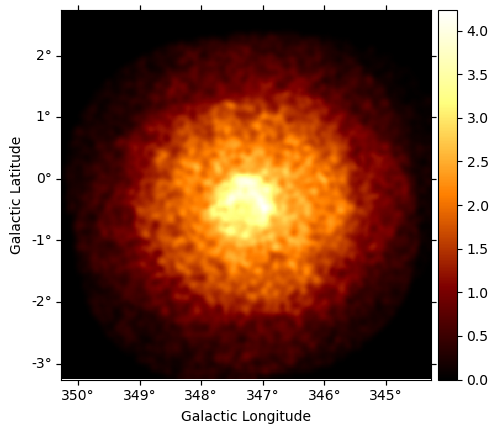

In [28]:
stacked.counts.reduce_over_axes().smooth(0.05*u.deg).plot(add_cbar=True)
plt.show()

Note: in the about plot I utilised the `reduce_over_axes` functionality. If you print the shape of the `counts` object, you will see that we have a third axis in energy which has the same amount of bins as we first defined for our `geom`. This function will reduce the non-spatial axes of the map (i.e. the energy axis), such that it just has 1 bin and can be plotted as a 2D figure with the `plot` functionality.



## Compute an excess and a significance map

In [29]:
estimator = ExcessMapEstimator(0.1 * u.deg, selection_optional=[], energy_edges=[0.4, 20]*u.TeV)
maps = estimator.run(stacked)

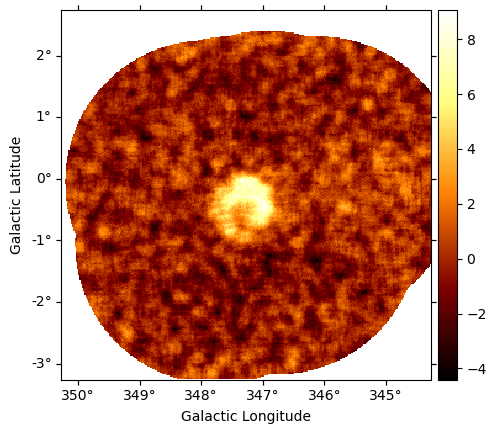

In [30]:
maps.sqrt_ts.plot(add_cbar=True)
plt.show()

### We can plot the excess and significance maps

<WCSAxes: title={'center': 'Excess map'}>

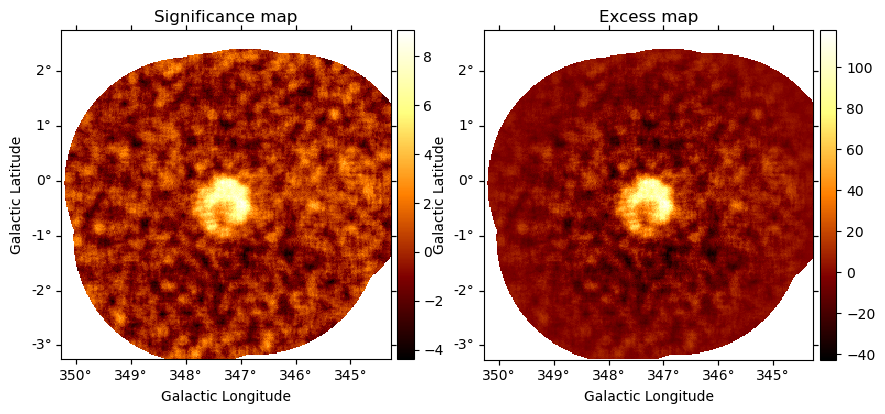

In [31]:
plt.figure(figsize=(10, 10))
ax1 = plt.subplot(221, projection=maps.sqrt_ts.geom.wcs)
ax2 = plt.subplot(222, projection=maps.sqrt_ts.geom.wcs)

ax1.set_title("Significance map")
maps.sqrt_ts.plot(ax=ax1, add_cbar=True)

ax2.set_title("Excess map")
maps.npred_excess.plot(ax=ax2, add_cbar=True)

### Can you create a map for the flux now?

Recall: it is possible to have autocompletion suggestions. Try it yourself with writing `maps.` and then press crtl+space

<WCSAxes: >

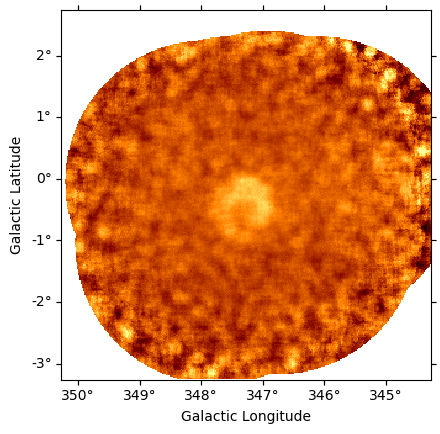

In [32]:
maps.flux.plot()

### What about a map in different energy bins?

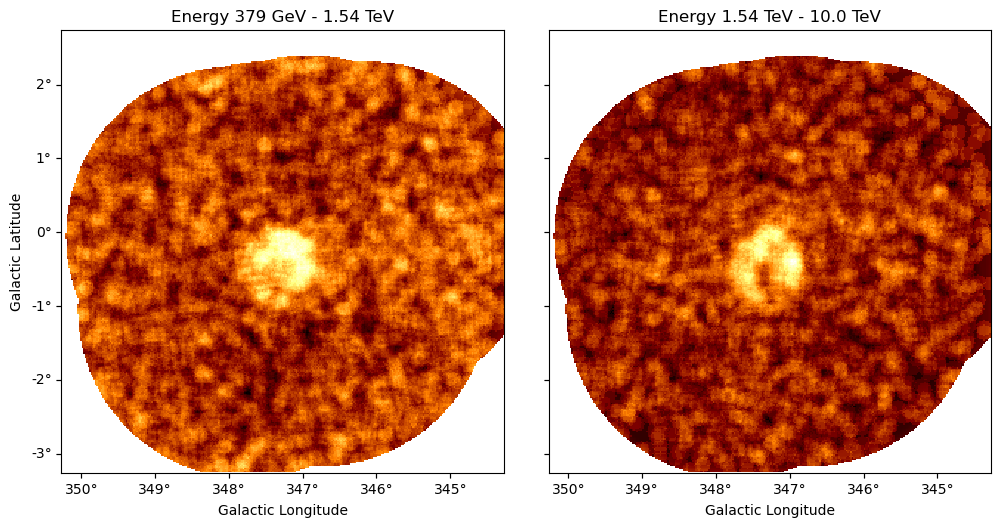

In [33]:
estimator2 = ExcessMapEstimator(0.1 * u.deg, selection_optional=[], energy_edges=[0.4, 1.5, 20]*u.TeV)
maps2 = estimator2.run(stacked)

maps2.sqrt_ts.plot_grid()
plt.show()

## Bonus: plot the exclusion mask on top of the image to ensure we excluded all significant emission from the background when we created the dataset

The exclusion mask was created based off a `region` so we can utilise its functionality to plot it. 

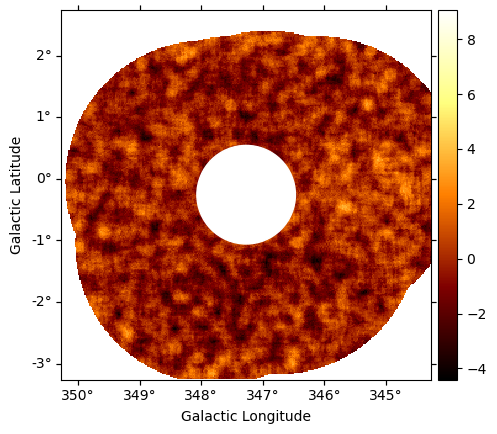

In [34]:
ax = maps.sqrt_ts.plot(add_cbar=True)

# First convert the circle to pixel coordinates based on the WCS of our map
region_pix = circle.to_pixel(ax.wcs)

# Then convert the region into an 'artist' which can be plot
# Include here any settings for the region, ie its color, fill style etc
artist = region_pix.as_artist(color='white', fill=True)

# Plot the artist
ax.add_artist(artist)

plt.show()

## Well done!!

## You have gone from DL3 data products to a DL4 dataset, which can be used for SCIENCE! 🥳